## Anomaly detection in Payments using ML

#import Libraries

In [0]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,recall_score, confusion_matrix
from sklearn.neighbors import KDTree

# Data Loading & Visulization

In [7]:
data=pd.read_csv(r'/content/drive/My Drive/creditcard.csv') 
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We can see above that there are 28 PCA components provided to us as it is not appropriate to provide someone's private details in dataset. Here We have another 2 features-Time and Amount. So there are total 30 features in our dataset. Label is provided to each Transaction i.e 0 for normal transaction and 1 for fraud transaction.

Time :- Number of seconds elapsed between this transaction and the first transaction in the dataset

Checking whether there is any missing value.


In [14]:
data.isnull().values.any()

False

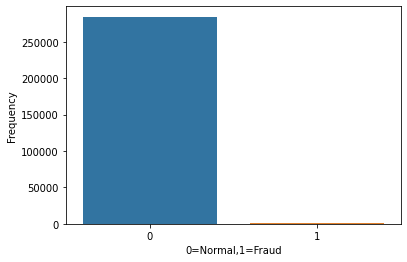

In [15]:
sns.countplot(x="Class",data=data)
plt.xlabel("0=Normal,1=Fraud")
plt.ylabel("Frequency")
plt.show()

In [16]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]
print("Number of fraud transactions :", len(fraud))
print("Number of normal transactions :", len(normal))
outlier_fraction = len(fraud)/float(len(normal))
print("Outlier Fraction:",outlier_fraction)

Number of fraud transactions : 492
Number of normal transactions : 284315
Outlier Fraction: 0.0017304750013189597


We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

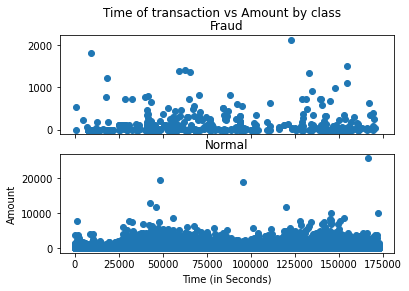

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

We Will check Do fraudulent transactions occur more often for certain amount ? Let us find out with a visual representation.

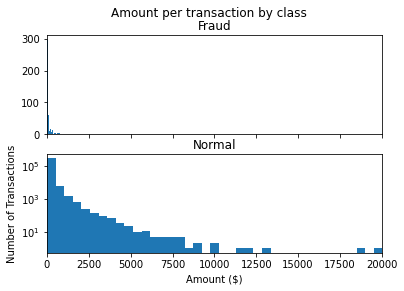

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Description of Fraudulent transactions

In [19]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
x=data.iloc[1:, 0:29]     
y=data.iloc[1:,30]
x=(x-np.mean(x))/np.std(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

#Logistic Regression

In [0]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
         # lr : Learning Rate
         # num_iter : Number of Iterations
         # fit_intercept : Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    # add column for intercept
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    # Sigmond Function
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # training function
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        # Gradient descent
        for _ in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
    # test function
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    def decision_function(self, X):
        return self.predict_prob(X).round()

LR training

In [0]:
model_lr = LogisticRegression(lr=0.01, num_iter=1000)
model_lr.fit(x_train, y_train)

LR testing

In [0]:
y_lr = model_lr.decision_function(x_test)

Confusion Matrix

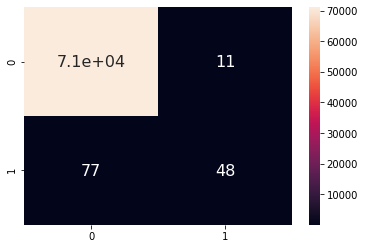

In [24]:
cm_lr = confusion_matrix(y_test,y_lr)
cm_lr_p = pd.DataFrame(cm_lr)
sns.heatmap(cm_lr_p, annot=True, annot_kws={"size": 16})

Recall & Errors

In [25]:
recall = recall_score(y_test, y_lr, pos_label=1)

print("Recall       :   ",recall)
print("Error Ratio  :   ",(cm_lr[0][1] + cm_lr[1][0])/len(y_test))

Recall       :    0.384
Error Ratio  :    0.0012359203393163113


#SVM

In [0]:
from sklearn.svm import SVC
model_svm = SVC()

SVM Training

In [117]:
model_svm.fit(X = x_train,y=y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVM testing

In [0]:
y_svm = model_svm.predict(x_test)

Confusion Matrix

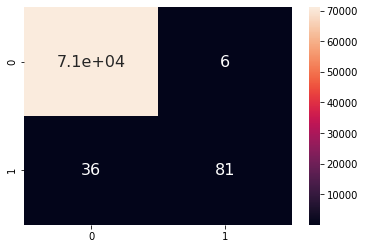

In [119]:
cm_svm = confusion_matrix(y_test,y_svm)
cm_svm_p = pd.DataFrame(cm_svm)
sns.heatmap(cm_svm_p, annot=True, annot_kws={"size": 16})

Recall & Error

In [120]:
recall = recall_score(y_test, y_svm, pos_label=1)

print("Recall       :   ",recall)
print("Error Ratio  :   ",(cm_svm[0][1] + cm_svm[1][0])/len(y_test))

Recall       :    0.6923076923076923
Error Ratio  :    0.0005898710710373304


#Isolation Forest

In [0]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix

class IsolationTreeEnsemble:
    def __init__(self, sample_size, n_trees=10):

        self.sample_size = sample_size
        self.n_trees = n_trees
        self.height_limit = np.log2(sample_size)
        self.trees = []

    def fit(self, X:np.ndarray, improved=False):
        """
        Given a 2D matrix of observations, create an ensemble of IsolationTree
        objects and store them in a list: self.trees.  Convert DataFrames to
        ndarray objects.
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
            len_x = len(X)
            col_x = X.shape[1]
            self.trees = []

        if improved:
            for i in range(self.n_trees):
                sample_idx = random.sample(list(range(len_x)), self.sample_size)
                temp_tree = IsolationTree(self.height_limit, 0).fit_improved(X[sample_idx, :], improved=True)
                self.trees.append(temp_tree)
        else:
            for i in range(self.n_trees):
                sample_idx = random.sample(list(range(len_x)), self.sample_size)
                temp_tree = IsolationTree(self.height_limit, 0).fit(X[sample_idx, :], improved=False)
                self.trees.append(temp_tree)

        return self

    def path_length(self, X:np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the average path length
        for each observation in X.  Compute the path length for x_i using every
        tree in self.trees then compute the average for each x_i.  Return an
        ndarray of shape (len(X),1).
        """
        pl_vector = []
        if isinstance(X, pd.DataFrame):
            X = X.values

        for x in (X):
            pl = np.array([path_length_tree(x, t, 0) for t in self.trees])
            pl = pl.mean()

            pl_vector.append(pl)

        pl_vector = np.array(pl_vector).reshape(-1, 1)

        return pl_vector

    def anomaly_score(self, X:np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """
        return 2.0 ** (-1.0 * self.path_length(X) / c(len(X)))

    def predict_from_anomaly_scores(self, scores:np.ndarray, threshold:float) -> np.ndarray:
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """

        predictions = [1 if p[0] >= threshold else 0 for p in scores]

        return predictions

    def predict(self, X:np.ndarray, threshold:float) -> np.ndarray:
        "A shorthand for calling anomaly_score() and predict_from_anomaly_scores()."

        scores = 2.0 ** (-1.0 * self.path_length(X) / c(len(X)))
        predictions = [1 if p[0] >= threshold else 0 for p in scores]

        return predictions

class IsolationTree:
    def __init__(self, height_limit, current_height):

        self.height_limit = height_limit
        self.current_height = current_height
        self.split_by = None
        self.split_value = None
        self.right = None
        self.left = None
        self.size = 0
        self.exnodes = 0
        self.n_nodes = 1

    def fit_improved(self, X: np.ndarray, improved=False):
        """
        Add Extra while loop
        """

        if len(X) <= 1 or self.current_height >= self.height_limit:
            self.exnodes = 1
            self.size = len(X)

            return self

        split_by = random.choice(np.arange(X.shape[1]))
        min_x = X[:, split_by].min()
        max_x = X[:, split_by].max()

        if min_x == max_x:
            self.exnodes = 1
            self.size = len(X)

            return self
        condition = True

        while condition:

            split_value = min_x + random.betavariate(0.5,0.5)*(max_x-min_x)

            a = X[X[:, split_by] < split_value]
            b = X[X[:, split_by] >= split_value]
            if len(X) < 10 or a.shape[0] < 0.25 * b.shape[0] or b.shape[0] < 0.25 * a.shape[0] or (
                    a.shape[0] > 0 and b.shape[0] > 0):
                condition = False

            self.size = len(X)
            self.split_by = split_by
            self.split_value = split_value

            self.left = IsolationTree(self.height_limit, self.current_height + 1).fit_improved(a, improved=False)
            self.right = IsolationTree(self.height_limit, self.current_height + 1).fit_improved(b, improved=False)
            self.n_nodes = self.left.n_nodes + self.right.n_nodes + 1

        return self

    def fit(self, X:np.ndarray, improved=False):
        """
        Given a 2D matrix of observations, create an isolation tree. Set field
        self.root to the root of that tree and return it.
        If you are working on an improved algorithm, check parameter "improved"
        and switch to your new functionality else fall back on your original code.
        """

        if len(X) <= 1 or self.current_height >= self.height_limit:
            self.exnodes = 1
            self.size = X.shape[0]

            return self

        split_by = random.choice(np.arange(X.shape[1]))
        X_col = X[:, split_by]
        min_x = X_col.min()
        max_x = X_col.max()

        if min_x == max_x:
            self.exnodes = 1
            self.size = len(X)

            return self

        else:

            split_value = min_x + random.betavariate(0.5, 0.5) * (max_x - min_x)

            w = np.where(X_col < split_value, True, False)
            del X_col

            self.size = X.shape[0]
            self.split_by = split_by
            self.split_value = split_value

            self.left = IsolationTree(self.height_limit, self.current_height + 1).fit(X[w], improved=True)
            self.right = IsolationTree(self.height_limit, self.current_height + 1).fit(X[~w], improved=True)
            self.n_nodes = self.left.n_nodes + self.right.n_nodes + 1

        return self



def find_recall_threshold(y, scores, desired_recall):
    """
    Start at score threshold 1.0 and work down until we hit desired TPR.
    Step by 0.01 score increments. For each threshold, compute the TPR
    and FPR to see if we've reached to the desired TPR. If so, return the
    score threshold and FPR.
    """
    threshold = 1

    while threshold > 0:
        y_pred = [1 if p[0] >= threshold else 0 for p in scores]
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        recall = tp / (tp + fn)
        if recall >= desired_recall:
            return threshold

        threshold = threshold - 0.001

    return threshold


def c(n):
    if n > 2:
        return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))
    elif n == 2:
        return 1
    if n == 1:
        return 0

def path_length_tree(x, t,e):
    e = e
    if t.exnodes == 1:
        e = e+ c(t.size)
        return e
    else:
        a = t.split_by
        if x[a] < t.split_value :
            return path_length_tree(x, t.left, e+1)

        if x[a] >= t.split_value :
            return path_length_tree(x, t.right, e+1)

Isolation model intialization & Fit Function

In [0]:
it = IsolationTreeEnsemble(sample_size=512, n_trees=100)

In [180]:
it.fit(x_test)

Calculate anomaly scores

In [0]:
scores = it.anomaly_score(x_test)

Find threshold for Optimal Results

In [0]:
threshold = find_recall_threshold(y_test,scores,0.8)

predict

In [0]:
y_iso = it.predict_from_anomaly_scores(scores, threshold)

Confusion Matrix

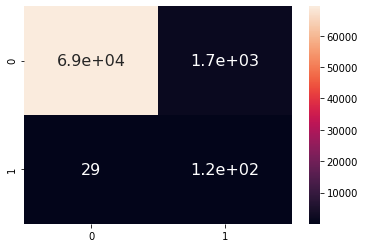

In [219]:
cm_iso = confusion_matrix(y_test,y_iso)
cm_iso_p = pd.DataFrame(cm_iso)
sns.heatmap(cm_iso_p, annot=True, annot_kws={"size": 16})

Recall & Error

In [227]:
recall = recall_score(y_test, y_iso, pos_label=1)

print("Recall       :   ",recall)
print("Error Ratio  :   ",(cm_iso[0][1] + cm_iso[1][0])/len(y_test))

Recall       :    0.8027210884353742
Error Ratio  :    0.024030223870116007


#Local Outlier Factor (LOF)

In [0]:
def LocalOutlierFactor(X, k):

    # KDtree is a space-partitioning data structure for organizing points in a k-dimensional space. 
    # X = dataset, leaf_size = Number of points at which to switch to brute-force. , p = 2 means a euclidean distance metric
    BT = KDTree(X, leaf_size=k, p=2)

    distance, index = BT.query(X, k)
    distance, index = distance[:, 1:], index[:, 1:] 
    radius = distance[:, -1]

    #Calculate Local Reachability Distance.
    LRD = np.mean(np.maximum(distance, radius[index]), axis=1)
    r = 1. / np.array(LRD)

    #Calculate outlier score.
    outlier_score = np.sum(r[index], axis=1) / np.array(r, dtype=np.float16)
    outlier_score *= 1. / k

    return outlier_score

def Lof_prdict(outlier_score, outlier_threshold = 1.2):
    # target class
    y = []

    # check whether given instance in outlier or not based on their outlier_score and outlier_threshold
    for i, score in enumerate(outlier_score):
        if score > outlier_threshold:
            y.append(1)
        else :
            y.append(0)

    return y

Find outlier_score

In [0]:
outlier_score = LocalOutlierFactor(x_test, k=100)

Predict

In [0]:
y_lof = Lof_prdict(outlier_score = outlier_score, outlier_threshold = 1.35)

Confusion Matrix

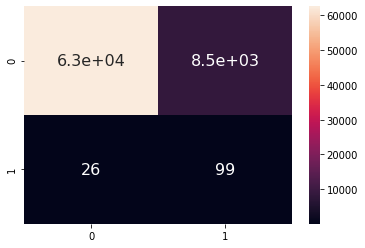

In [83]:
cm_lof = confusion_matrix(y_test,y_lof)
cm_lof_p = pd.DataFrame(cm_lof)
sns.heatmap(cm_lof_p, annot=True, annot_kws={"size": 16})

Recall & Error

In [84]:
recall = recall_score(y_test, y_lof, pos_label=1)

print("Recall       :   ",recall)
print("Error Ratio  :   ",(cm_lof[0][1] + cm_lof[1][0])/len(y_test))

Recall       :    0.792
Error Ratio  :    0.11913991180023033
